# 4.5 Comparing Sentinel-1 RTC datasets

So far in this tutorial, we've demonstrated how to read Sentinel-1 RTC imagery from two sources and assemble analysis-ready data cubes with appropriate metadata. Now, we'll perform a comparison of the two datasets. 

::::{tab-set}
:::{tab-item} Dataset comparison

While the two datasets are very similar, there are a few key differences:  
1) They use different sources images.   
    - ASF Sentinel-1 RTC imagery is processed from Single Look Complex ([SLC](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/single-look-complex)) images while Planetary Computer Sentinel-1 RTC imagery is processed from Ground Range Detected ([GRD](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/ground-range-detected)) images. SLC images contain both amplitude and phase information for each pixel. They are in radar coordinates and have not yet been multi-looked. In contrast, GRD images has been detected, multi-looked and projected to ground range.

2) They use different digital elevation models (DEMs) for terrain correction.  
    - ASF uses the [GLO-30 Copernicus DEM](https://dataspace.copernicus.eu/explore-data/data-collections/copernicus-contributing-missions/collections-description/COP-DEM) while Planetary Computer uses a Planet DEM.  
3) The datasets have different pixel spacings. For Planetary Computer, the pixel spacing is 10m in both range and azimuth directions. ASF has the option to produce images with 30 m, 20 m, or 10 m pixel spacing. The data used in this tutorial is 30 m. Note that there are tradeoffs in processing time and file size with pixel spacing, see more discussion [here](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#pixel-spacing_1).  
4) Each platform uses a different algorithm for RTC processing.
5) The ASF dataset comes with an associated layover shadow map for each scene while the Planetary Computer dataset does not.  

All of the above information and much more detail about the processing methods for both datasets are available in each dataset's documentation pages:
- [ASF Sentinel-1 RTC Product Guide](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#pixel-spacing_1)  
- [Microsoft Planetary Computer Sentinel-1 RTC dataset](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) 
::: 

:::{tab-item} Outline

(content.Section_A)=
**[A. Read and prepare data](#a-read-and-prepare-data)**  
- 1) Check coordinate reference system information

(content.Section_B)=
**[B. Ensure direct comparison between datasets](#b-ensure-direct-comparison-between-datasets)**
- 1) Subset time series to common time steps
- 2) Handle differences in spatial resolution
- 3) Mask missing data from one dataset

(content.Section_C)=
**[C. Combine objects](#c-combine-objects)**
- 1) `expand_dims()` to add 'source' dimension
- 2) `combine_by_coords()`

(content.Section_D)=
**[D. Visualize comparisons](#d-visualize-comparisons)**
- 1) Mean over time
- 2) Mean over space

:::
:::{tab-item} Learning goals

#### Concepts
- Comparing and evaluating multiple datasets
- Organizing data so that its structure matches your use-case

#### Techniques
- Conditional selection based on non-dimensional coordinates using `xr.Dataset.where()`
- Subsetting datasets based on dimensional coordinates using `xr.DataArray.isin()`
- Adding dimensional and non-dimensional coordinates to `xr.Dataset` objects
- Xarray plotting methods
- Projecting xarray objects to different grids using `xr.interp_like()`
:::
::::


In [4]:
# %xmode minimal
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import warnings

import s1_tools

warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

{{break}}

## A. Read and prepare data

At the end of notebook 3, we wrote the analysis-ready ASF Sentinel-1 data cube that had been clipped to a smaller spatial area of interest to disk. We'll read that into memory now to use in this comparison.

We used Jupyter cell magic to persist the Planetary Computer data cube created in notebook 4. Now we can read it into our notebook by adding `-r` to the store magic command used to persist it. Read more about `storemagic` [here](https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html).

In [5]:
%store -r da
pc_cube = da

In [6]:
pc_cube = pc_cube.compute()

In [7]:
timeseries_type = "full"

asf_cube = xr.open_dataset(
    f"../data/raster_data/{timeseries_type}_timeseries/intermediate_cubes/s1_asf_clipped_cube.zarr",
    engine="zarr",
    chunks="auto",
    decode_coords="all",
)

Rename the temporal dimension of the ASF dataset to match that of the PC dataset:

In [8]:
asf_cube = asf_cube.rename({"acq_date": "time"})

In [9]:
asf_cube = asf_cube.compute()

### 1) Check coordinate reference system information

First, make sure that both objects are projected to the same CRS.

In [10]:
assert pc_cube.rio.crs == asf_cube.rio.crs, "CRS of both data cubes are expected to be identical."

Let's also check how missing data is handled in both objects. We want missing data to be assigned NaN values.

In [11]:
asf_cube["vv"].rio.nodata

nan

In [12]:
pc_cube.sel(band="vv").rio.nodata

The `pc_cube` array contains nan values, but it doesn't have an encoding specifying what value is used to represent nodata. We can assign a nodata value to the dataset below. See Rioxarray's [Nodata Management documentation](https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html) for more detail on this.

In [13]:
pc_cube.rio.write_nodata(np.nan, inplace=True)
pc_cube.rio.nodata

nan

In [14]:
assert (
    np.isnan(asf_cube.vh.rio.nodata) == np.isnan(pc_cube.sel(band="vh").rio.nodata) == True
), "Expected vh nodata value to be np.nan"
assert (
    np.isnan(asf_cube.vv.rio.nodata) == np.isnan(pc_cube.sel(band="vv").rio.nodata) == True
), "Expected vv nodata value to be np.nan"

## B. Ensure direct comparison between datasets

In notebook 3, we removed time steps from the ASF time series where the area of interest was only partially covered by the satellite footprint. Let's do the same for the PC dataset: 

Thanks to all of the metadata wrangling we did in earlier notebooks, we can quickly access information needed to ensure a direct comparison of time steps between the two datasets

### 1) Subset time series to common time steps

Make a list of the acquisition dates in the ASF time series:

In [15]:
asf_acq_dates = asf_cube.time.dt.date.data.tolist()

Subset the PC time series to only the time steps that exist in the ASF time series:

In [16]:
pc_subset = pc_cube.where(pc_cube.time.dt.date.isin(asf_acq_dates), drop=True)

Make sure that the time steps we're excluding only have partial coverage:

In [17]:
pc_outtakes = (
    pc_cube.where(~pc_cube.time.dt.date.isin(asf_acq_dates), drop=True).to_dataset(dim="band").drop_dims("band")
)

In [18]:
max_pixels = pc_outtakes.mean(dim="time").x.shape[0] * pc_outtakes.mean(dim="time").y.shape[0]
valid_pixels = pc_outtakes.vv.count(dim=["x", "y"])
pc_outtakes["cov"] = (valid_pixels / max_pixels) * 100

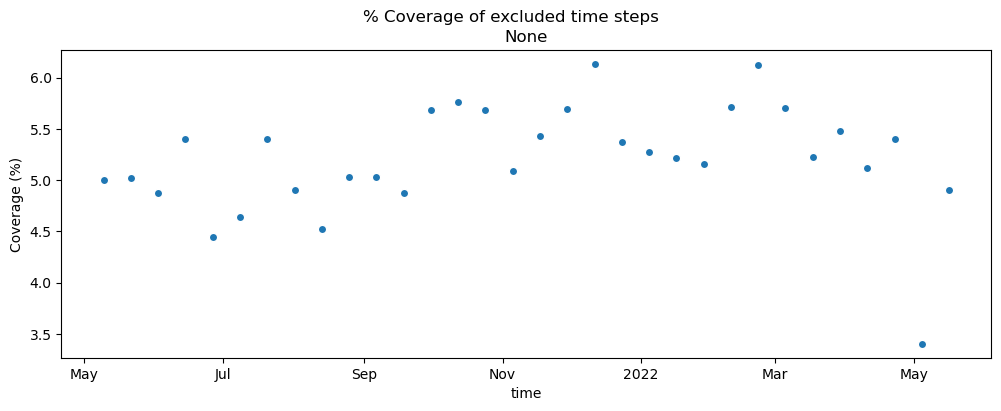

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
pc_outtakes.cov.plot.scatter(x="time", y="cov", ax=ax)
ax.set_ylabel("Coverage (%)")
ax.set_title("None")
fig.suptitle("% Coverage of excluded time steps");
# ax.set_ylim(0,100);

Great, we've successfully removed the time steps with limited coverage. Make sure that the time steps of the two datasets are now identical:

In [20]:
np.testing.assert_array_equal(asf_cube.time.dt.date.data, pc_subset.time.dt.date.data)

Now that we know we are looking at the same time steps across the two datasets, let's take a look at the data for a few individual scenes side-by-side to get a better image of the differences still remaining between the two data cubes. 


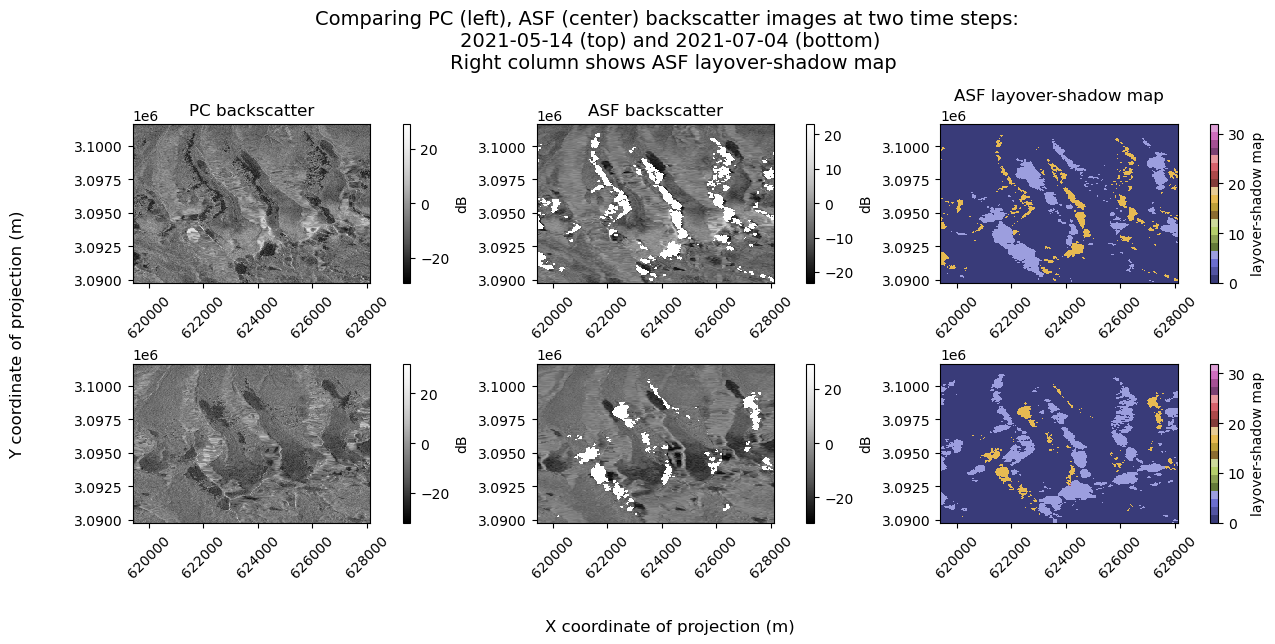

In [21]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 5), layout="constrained")

backscatter_kwargs = {"cmap": "Greys_r", "cbar_kwargs": {"label": "dB"}}
ls_kwargs = {
    "cmap": "tab20b",
    "vmin": 0,
    "vmax": 32,
    "cbar_kwargs": {"label": "layover-shadow map"},
}

s1_tools.power_to_db(pc_subset.isel(time=1).sel(band="vv")).plot(ax=axs[0][0], **backscatter_kwargs)
s1_tools.power_to_db(asf_cube.isel(time=1)).vv.plot(ax=axs[0][1], **backscatter_kwargs)
asf_cube.isel(time=1).ls.plot(ax=axs[0][2], **ls_kwargs)

s1_tools.power_to_db(pc_subset.isel(time=10).sel(band="vv")).plot(ax=axs[1][0], **backscatter_kwargs)
s1_tools.power_to_db(asf_cube.isel(time=10)).vv.plot(ax=axs[1][1], **backscatter_kwargs)
asf_cube.isel(time=10).ls.plot(ax=axs[1][2], **ls_kwargs)

col_names = ["PC backscatter", "ASF backscatter", "ASF layover-shadow map"]

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        if i == 0:
            axs[i, j].set_title(col_names[j])
        else:
            axs[i, j].set_title(None)

        axs[i, j].tick_params(axis="x", labelrotation=45)
        axs[i, j].set_ylabel(None)
        axs[i, j].set_xlabel(None)

fig.supylabel("Y coordinate of projection (m)", x=-0.05)
fig.supxlabel("X coordinate of projection (m)", y=-0.10)
fig.suptitle(
    f"Comparing PC (left), ASF (center) backscatter images at two time steps: \n {asf_cube.isel(time=1).time.dt.date.data.astype(str)} (top) and {asf_cube.isel(time=10).time.dt.date.data.astype(str)} (bottom) \n Right column shows ASF layover-shadow map",
    fontsize=14,
    y=1.15,
);

As discussed at the top of this notebook, the PC dataset has a higher spatial resolution than the ASF dataset. The ASF dataset masks pixels that are in radar shadow on the associated layover-shadow map. The PC dataset does not mask out pixels in the same way the the ASF dataset does. It appears that many pixels near the masked regions in the ASF dataset are very dark, and that they are smaller than the shadow regions in the ASF images, which makes sense given the higher spatial resolution. 

To compare the two backscatter datasets, we need to align them on a common spatial grid and apply the same mask that the ASF dataset has to the PC dataset. 

### 2) Handle differences in spatial resolution

Different approaches to regrid the dataset exist. Here, we will use `xr.interp_like()`. For more discussion and examples of regridding approaches with Xarray, we recommend the Project Pythia Cookbook, [*(re)Gridding with Xarray*](https://projectpythia.org/gridding-cookbook/README.html).

In [22]:
asf_da = asf_cube.to_dataarray(dim="band")

In [23]:
pc_downsample = pc_subset.interp_like(asf_da)

Check that the x and y dimensions of the ASF and PC datasets are the same:

In [24]:
assert set(asf_da.shape) == set(pc_downsample.shape)

In [25]:
# We don't use xr.da.equals() because the coords are not the same
np.testing.assert_array_equal(asf_da.x.data, pc_downsample.x.data)
np.testing.assert_array_equal(asf_da.y.data, pc_downsample.y.data)

Take a look at the downsampled object:

In [26]:
pc_downsample

<xarray.DataArray 'stackstac-9bcc6847bcc8aaa157107857cb7c5801' (time: 63,
                                                                band: 2,
                                                                y: 396, x: 290)> Size: 116MB
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [0.04549962, 0.01855338, 0.12647254, ..., 0.06789518,
          0.08521891, 0.13681663],
         [0.03346461, 0.02266538, 0.0254462 , ..., 0.07946561,
          0.06234075, 0.06531374],
         [0.06862071, 0.03021182, 0.02592285, ..., 0.05753639,
          0.04578133, 0.04019741]],

        [[0.09181641, 0.13255357, 0.11439105, ..., 0.02990846,
          0.06167883, 0.10338417],
         [0.03605805, 0.07709991, 0.06179178, ..., 0.06324495,
          0.06967352, 0.06998518],
         [0.083302  , 0.06709625, 0.03545287, ..., 0.13871263,
          0.16923995, 0.09101553],
         ...,
         [0.13841812, 0.06780505, 0.18767709, ..., 0.20274199,
          0.28472821, 0.59514235],
         [0.1202446 , 0.05192094, 0.12619685, ..., 0.30397775,
          0.51694893, 0.77399951],
         [0.10203732, 0.07558257, 0.1055893 , ..., 0.18922102,
          0.93601959, 0.63039715]]]])
Coordinates: (12/39)
  * band                                   (band) <U2 16B 'vh' 'vv'
    sar:center_frequency                   float64 8B 5.405
    sat:absolute_orbit                     (time) float64 504B nan ... 4.331e+04
    sar:looks_equivalent_number            float64 8B 4.4
    platform                               <U11 44B 'SENTINEL-1A'
    sar:product_type                       <U3 12B 'GRD'
    ...                                     ...
    s1:slice_number                        (time) <U2 504B '12' '6' ... '6' '6'
    s1:datatake_id                         (time) <U6 2kB '291939' ... '338944'
    s1:instrument_configuration_ID         (time) <U1 252B '6' '6' ... '7' '7'
    sat:orbit_state                        (time) <U10 3kB 'descending' ... '...
    end_datetime                           (time) <U32 8kB '2021-05-05 00:03:...
    s1:orbit_source                        (time) <U8 2kB 'DOWNLINK' ... 'RES...
Attributes:
    spec:           RasterSpec(epsg=32645, bounds=(619419.5314582244, 3089781...
    crs:            epsg:32645
    transform:      | 9.79, 0.00, 619419.53|\n| 0.00,-7.70, 3101655.25|\n| 0....
    resolution_xy:  (9.788706070864338, 7.699930607059487)
    _FillValue:     nan

`xr.interp_like()` interpolates the values from the PC dataset (`pc_subset`) onto the grid of `asf_da`. Notice that, while the resultant object has the expected dimensions, the band dimension is not indexed. To fix this, use [`xr.set_index()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.set_index.html) to create an index from the `band` coordinate variable.

In [27]:
pc_downsample = pc_downsample.set_index(band='band')
pc_downsample

<xarray.DataArray 'stackstac-9bcc6847bcc8aaa157107857cb7c5801' (time: 63,
                                                                band: 2,
                                                                y: 396, x: 290)> Size: 116MB
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [0.04549962, 0.01855338, 0.12647254, ..., 0.06789518,
          0.08521891, 0.13681663],
         [0.03346461, 0.02266538, 0.0254462 , ..., 0.07946561,
          0.06234075, 0.06531374],
         [0.06862071, 0.03021182, 0.02592285, ..., 0.05753639,
          0.04578133, 0.04019741]],

        [[0.09181641, 0.13255357, 0.11439105, ..., 0.02990846,
          0.06167883, 0.10338417],
         [0.03605805, 0.07709991, 0.06179178, ..., 0.06324495,
          0.06967352, 0.06998518],
         [0.083302  , 0.06709625, 0.03545287, ..., 0.13871263,
          0.16923995, 0.09101553],
         ...,
         [0.13841812, 0.06780505, 0.18767709, ..., 0.20274199,
          0.28472821, 0.59514235],
         [0.1202446 , 0.05192094, 0.12619685, ..., 0.30397775,
          0.51694893, 0.77399951],
         [0.10203732, 0.07558257, 0.1055893 , ..., 0.18922102,
          0.93601959, 0.63039715]]]])
Coordinates: (12/39)
  * band                                   (band) <U2 16B 'vh' 'vv'
    sar:center_frequency                   float64 8B 5.405
    sat:absolute_orbit                     (time) float64 504B nan ... 4.331e+04
    sar:looks_equivalent_number            float64 8B 4.4
    platform                               <U11 44B 'SENTINEL-1A'
    sar:product_type                       <U3 12B 'GRD'
    ...                                     ...
    s1:slice_number                        (time) <U2 504B '12' '6' ... '6' '6'
    s1:datatake_id                         (time) <U6 2kB '291939' ... '338944'
    s1:instrument_configuration_ID         (time) <U1 252B '6' '6' ... '7' '7'
    sat:orbit_state                        (time) <U10 3kB 'descending' ... '...
    end_datetime                           (time) <U32 8kB '2021-05-05 00:03:...
    s1:orbit_source                        (time) <U8 2kB 'DOWNLINK' ... 'RES...
Attributes:
    spec:           RasterSpec(epsg=32645, bounds=(619419.5314582244, 3089781...
    crs:            epsg:32645
    transform:      | 9.79, 0.00, 619419.53|\n| 0.00,-7.70, 3101655.25|\n| 0....
    resolution_xy:  (9.788706070864338, 7.699930607059487)
    _FillValue:     nan

Great, now the data are aligned on the same spatial grid with proper indexes, but we still need to mask the data in the PC dataset categorized as 'shadow' in the ASF dataset.

### 3) Mask missing data from one dataset

We'll use [`xr.where()`](https://docs.xarray.dev/en/stable/generated/xarray.where.html) to assign NaN to all pixels in the PC dataset where the corresponding pixel in the ASF dataset is NaN:

In [28]:
pc_mask = xr.where(asf_da.notnull(), pc_downsample, np.nan)

Let's check that the masking operation did what we expect it to do:

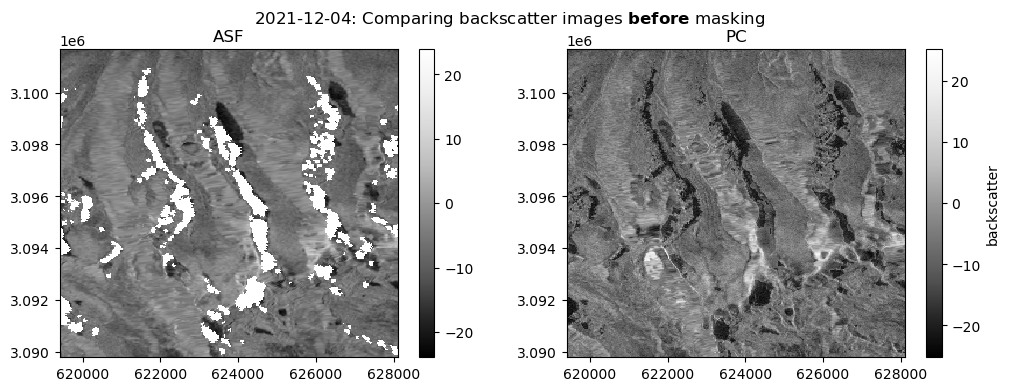

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

date_target = "2021-12-2"
date_actual = asf_da.sel(time=date_target, method="nearest").time.dt.date.data.astype(str)
fig.suptitle(f"{date_actual}: Comparing backscatter images " + r"$\bf{before}$" + " masking")
s1_tools.power_to_db(asf_da.sel(band="vv").sel(time=date_target, method="nearest")).plot(cmap=plt.cm.Greys_r, ax=ax[0])
ax[0].set_title("ASF")
s1_tools.power_to_db(pc_downsample.sel(band="vv").sel(time=date_target, method="nearest")).plot(
    cmap=plt.cm.Greys_r, ax=ax[1], cbar_kwargs={"label": "backscatter"}
)
ax[1].set_title("PC")

ax[0].set_ylabel(None)
ax[0].set_xlabel(None)

ax[1].set_ylabel(None)
ax[1].set_xlabel(None);

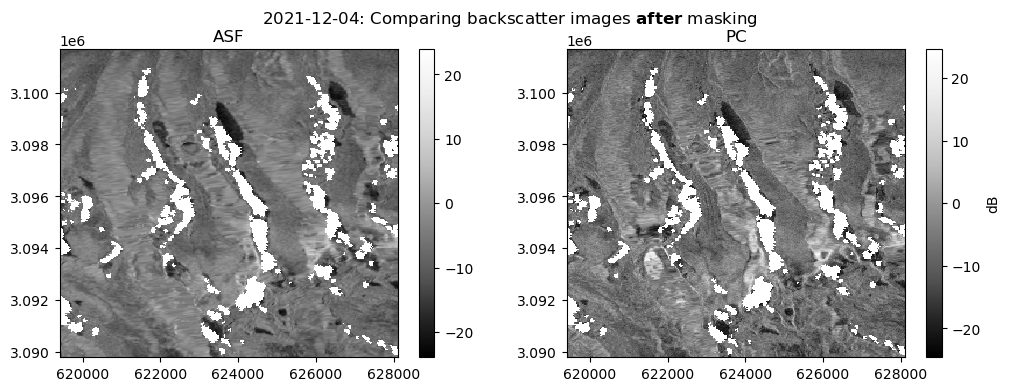

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

date_target = "2021-12-2"
date_actual = asf_da.sel(time=date_target, method="nearest").time.dt.date.data.astype(str)
fig.suptitle(f"{date_actual}: Comparing backscatter images " + r"$\bf{after}$" + " masking")
s1_tools.power_to_db(asf_da.sel(band="vv").sel(time=date_target, method="nearest")).plot(cmap=plt.cm.Greys_r, ax=ax[0])
ax[0].set_title("ASF")
s1_tools.power_to_db(pc_mask.sel(band="vv").sel(time=date_target, method="nearest")).plot(
    cmap=plt.cm.Greys_r, ax=ax[1], cbar_kwargs={"label": "dB"}
)
ax[1].set_title("PC")

ax[0].set_ylabel(None)
ax[0].set_xlabel(None)

ax[1].set_ylabel(None)
ax[1].set_xlabel(None);

## C. Combine objects

The two datasets are ready to compare. So far in this book, we've been treating each data cube as an independent unit of analysis containing backscatter data, so it made sense to have dimensions `('x','y','time')` or `('x','y','time','band')`. Now, we're interested in comparing the backscatter values between the two datasets. In effect, this new objective implies a new dimension on the data cube, `'source'`.

### 1) `expand_dims()` to add 'source' dimension

In [31]:
asf_da = asf_da.expand_dims("source")
pc_mask = pc_mask.expand_dims("source")

In [32]:
asf_da["source"] = ("source", ["asf"])
pc_mask["source"] = ("source", ["pc"])

### 2) `combine_by_coords()`

Now both datasets can be combined into a single data cube along the `'source'` dimension:

In [33]:
comparison_obj = xr.combine_by_coords([asf_da, pc_mask])
comparison_obj

<xarray.DataArray (source: 2, band: 2, time: 63, y: 396, x: 290)> Size: 232MB
array([[[[[0.01555569, 0.01491176, 0.0143311 , ..., 0.01184858,
           0.0117538 , 0.00992225],
          [0.01360236, 0.01293999, 0.01243569, ..., 0.01579912,
           0.0168997 , 0.01891696],
          [0.01288445, 0.01205768, 0.01015107, ..., 0.01416875,
           0.01364833, 0.01188905],
          ...,
          [0.06956345, 0.07556403, 0.08035918, ..., 0.05665181,
           0.04925308, 0.04496128],
          [0.05155516, 0.05226098, 0.04978541, ..., 0.0639898 ,
           0.05680224, 0.0511563 ],
          [0.04902361, 0.04870481, 0.0455279 , ..., 0.06262416,
           0.07074987, 0.05973238]],

         [[0.01492812, 0.01373455, 0.01557156, ..., 0.0109483 ,
           0.00884879, 0.01020105],
          [0.01335062, 0.01543668, 0.01365704, ..., 0.00834289,
           0.00747976, 0.01026701],
          [0.01182555, 0.01532262, 0.01113879, ..., 0.00709354,
           0.00555609, 0.01234658],
...
          [       nan, 0.11642265, 0.37465498, ..., 0.20789409,
           0.2771877 ,        nan],
          [0.16054228, 0.07675173, 0.2105077 , ..., 0.18713439,
           0.67867831, 0.57523444],
          [0.21466168, 0.0884462 , 0.10803856, ..., 0.18703819,
           0.61164559, 0.32279881]],

         [[0.09181641, 0.13255357, 0.11439105, ..., 0.02990846,
           0.06167883, 0.10338417],
          [0.03605805, 0.07709991, 0.06179178, ..., 0.06324495,
           0.06967352, 0.06998518],
          [0.083302  , 0.06709625, 0.03545287, ..., 0.13871263,
           0.16923995, 0.09101553],
          ...,
          [       nan, 0.06780505, 0.18767709, ..., 0.20274199,
           0.28472821,        nan],
          [0.1202446 , 0.05192094, 0.12619685, ..., 0.30397775,
           0.51694893, 0.77399951],
          [0.10203732, 0.07558257, 0.1055893 , ..., 0.18922102,
           0.93601959, 0.63039715]]]]])
Coordinates: (12/46)
    abs_orbit_num                          (time) <U6 2kB '037745' ... '043309'
  * time                                   (time) datetime64[ns] 504B 2021-05...
    data_take_ID                           (time) <U6 2kB '047463' ... '052C00'
    ls                                     (time, y, x) float64 58MB 1.0 ... 1.0
    orbital_dir                            (time) <U4 1kB 'asc' ... 'desc'
    product_id                             (time) <U4 1kB '54B1' ... 'CA1B'
    ...                                     ...
    s1:slice_number                        (time) <U2 504B '12' '6' ... '6' '6'
    s1:datatake_id                         (time) <U6 2kB '291939' ... '338944'
    s1:instrument_configuration_ID         (time) <U1 252B '6' '6' ... '7' '7'
    sat:orbit_state                        (time) <U10 3kB 'descending' ... '...
    end_datetime                           (time) <U32 8kB '2021-05-05 00:03:...
    s1:orbit_source                        (time) <U8 2kB 'DOWNLINK' ... 'RES...
Attributes: (12/13)
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    ...                                ...
    polarization_type:                 D
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    terrain_correction_pixel_spacing:  RTC30
    unmasked_or_watermasked:           u

## D. Visualize comparisons

We're ready to visualize backscatter from both datasets. Because we've made a data cube whose dimensionality reflects the comparison, we can use Xarray's plotting features and visualize the comparisons from a single object.

### 1) Mean over time

Look at VV backscatter first:

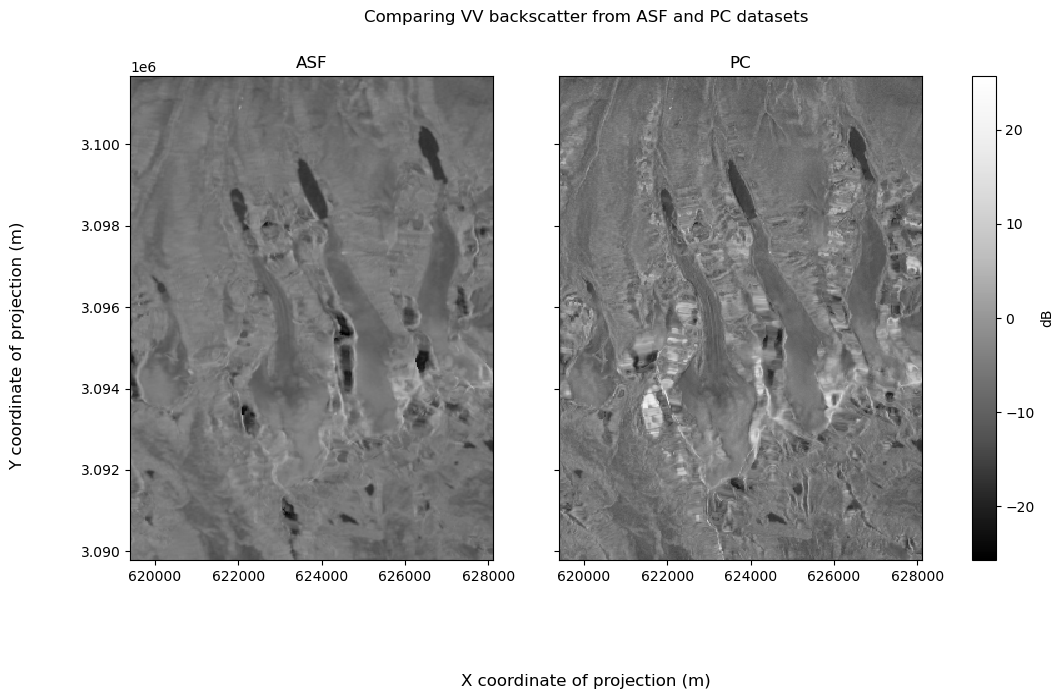

In [34]:
# Plot backscatter data
vv_fg = s1_tools.power_to_db(comparison_obj.sel(band="vv").mean(dim="time")).plot(
    col="source", cmap=plt.cm.Greys_r, cbar_kwargs=({"label": "dB"})
)
# Format figure and axes
vv_fg.fig.suptitle("Comparing VV backscatter from ASF and PC datasets")
vv_fg.fig.supxlabel("X coordinate of projection (m)")
vv_fg.fig.supylabel("Y coordinate of projection (m)")
vv_fg.fig.set_figheight(7)
vv_fg.fig.set_figwidth(12)

for i in range(len(vv_fg.axs[0])):
    vv_fg.axs[0][i].set_xlabel(None)
    vv_fg.axs[0][i].set_ylabel(None)
vv_fg.axs[0][0].set_title("ASF")
vv_fg.axs[0][1].set_title("PC");

Then VH:

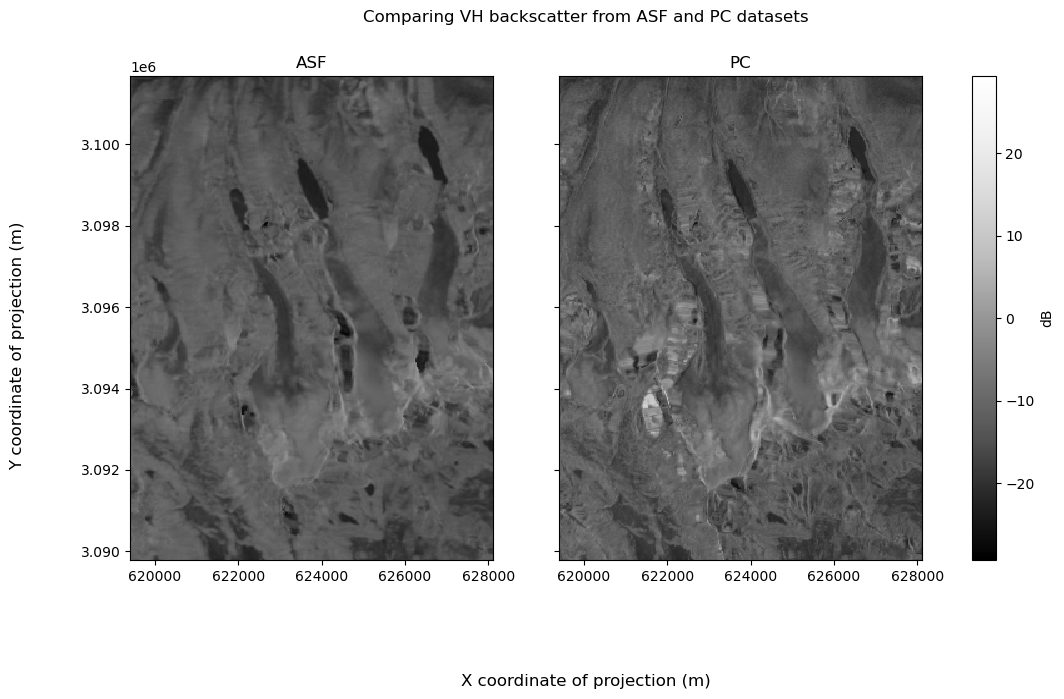

In [35]:
# Plot backscatter data
vh_fg = s1_tools.power_to_db(comparison_obj.sel(band="vh").mean(dim="time")).plot(
    col="source", cmap=plt.cm.Greys_r, cbar_kwargs=({"label": "dB"})
)

# Figure and axes formatting
vh_fg.fig.suptitle("Comparing VH backscatter from ASF and PC datasets")
vh_fg.fig.supxlabel("X coordinate of projection (m)")
vh_fg.fig.supylabel("Y coordinate of projection (m)")
vh_fg.fig.set_figheight(7)
vh_fg.fig.set_figwidth(12)
for i in range(len(vh_fg.axs[0])):
    vh_fg.axs[0][i].set_xlabel(None)
    vh_fg.axs[0][i].set_ylabel(None)
vh_fg.axs[0][0].set_title("ASF")
vh_fg.axs[0][1].set_title("PC");

### 2) Mean over space

Instead of computing mean backscatter values along the time dimension, reduce along the spatial dimensions (x and y) to see backscatter variability over time:

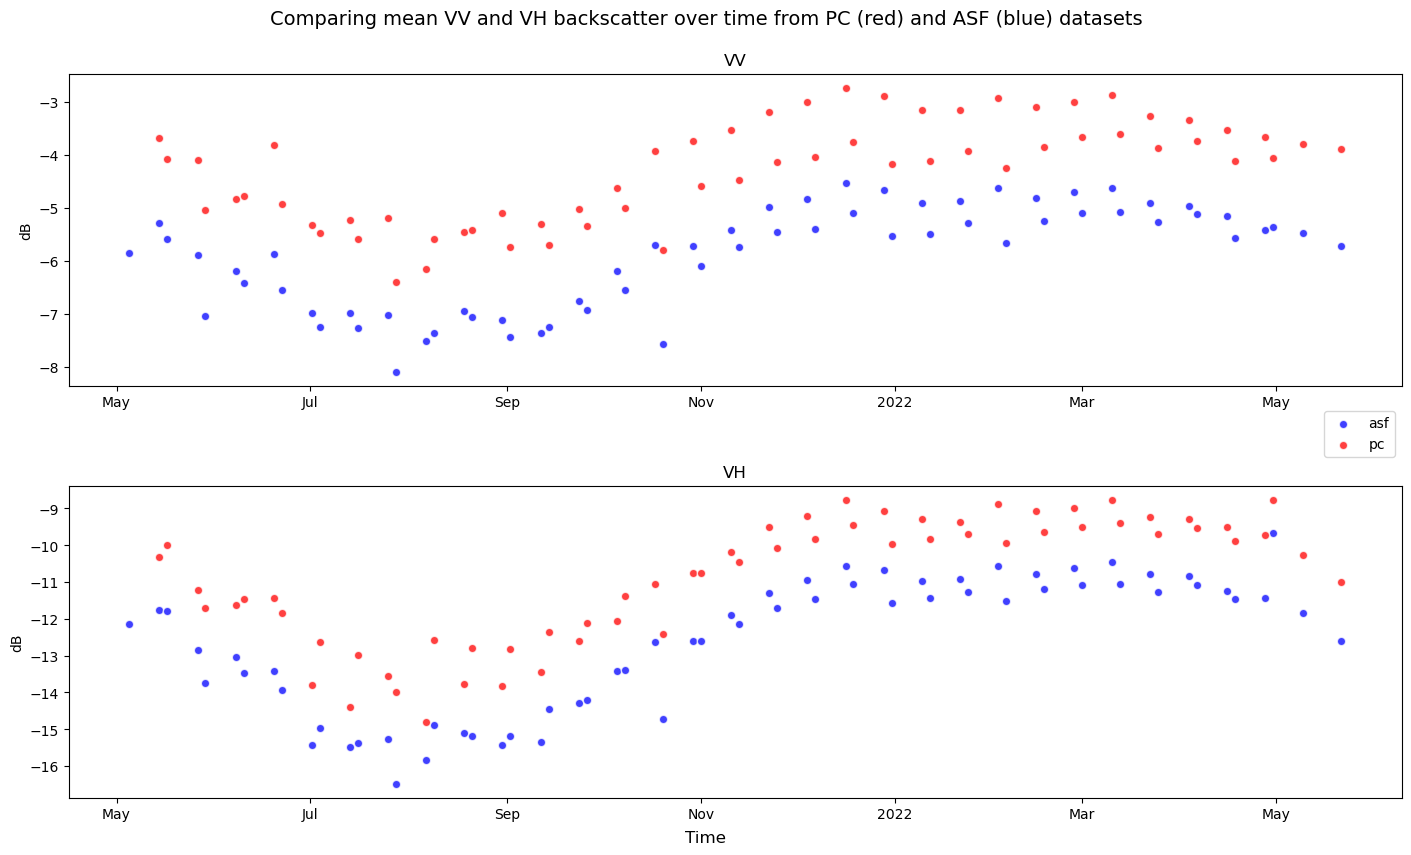

In [36]:
fig, ax = plt.subplots(nrows=2, figsize=(14, 8), layout="constrained")
s1_tools.power_to_db(comparison_obj.sel(source="asf", band="vv").mean(dim=["x", "y"])).plot.scatter(
    x="time", ax=ax[0], label="asf", c="b", alpha=0.75
)
s1_tools.power_to_db(comparison_obj.sel(source="pc", band="vv").mean(dim=["x", "y"])).plot.scatter(
    x="time", ax=ax[0], label="pc", c="r", alpha=0.75
)

s1_tools.power_to_db(comparison_obj.sel(source="asf", band="vh").mean(dim=["x", "y"])).plot.scatter(
    x="time", ax=ax[1], label="asf", c="b", alpha=0.75
)
s1_tools.power_to_db(comparison_obj.sel(source="pc", band="vh").mean(dim=["x", "y"])).plot.scatter(
    x="time", ax=ax[1], label="pc", c="r", alpha=0.75
)
ax[0].legend(loc="lower right", bbox_to_anchor=([1, -0.25, 0, 0]))

for i in range(len(ax)):
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("dB")

ax[0].set_title("VV")
ax[1].set_title("VH")

fig.supxlabel("Time")
# fig.supylabel('dB')
fig.suptitle(
    "Comparing mean VV and VH backscatter over time from PC (red) and ASF (blue) datasets",
    fontsize=14,
    y=1.05,
);

We can also use `hvplot` to make an interactive visualization of this comparison:

In [37]:
asf_plot = s1_tools.power_to_db(
    comparison_obj.sel(source="asf").to_dataset(dim="band")["vv"].mean(dim=["x", "y"])
).hvplot.scatter(x="time", label="asf")
pc_plot = s1_tools.power_to_db(
    comparison_obj.sel(source="pc").to_dataset(dim="band")["vv"].mean(dim=["x", "y"])
).hvplot.scatter(x="time", label="pc")

asf_plot * pc_plot

:Overlay
   .Scatter.Asf :Scatter   [time]   (vv)
   .Scatter.Pc  :Scatter   [time]   (vv)

## Conclusion